<a href="https://colab.research.google.com/github/fabiodr/colabs/blob/main/FAFB_all_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setting up

In [ ]:
%%capture
!pip install git+https://github.com/YijieYin/connectome_interpreter.git --no-deps
# download pre-computed indirect connectivity - only needed for result_summary()
# FAFB
!gdown --folder 1xfGomfsMjXvSJHWTk8G6GcviBfwH2wW1

In [ ]:
%%capture
# optional dependency, only needed for any information-flow-related functions: layered_el(), plot_flow_layered_paths()
!pip install navis -U
# optional dependency, needed for any interactive plotting
!pip install pyvis
%%capture
# optional dependency, neuroglancer visualisation
!pip3 install git+https://github.com/schlegelp/nglscenes@main

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from connectome_interpreter import *

In [ ]:
import nglscenes as ngl
import matplotlib.colors as mcl

In [ ]:
inprop = read_precomputed('fafb_all_neuron', first_n=1)[0]

In [ ]:
# these lines are only needed for result_summary(), and are somewhat RAM-intensive
steps = read_precomputed('fafb_all_neuron', first_n=4)
stepsn = add_first_n_matrices(steps, len(steps))

In [ ]:
meta = pd.read_csv('https://raw.githubusercontent.com/YijieYin/connectome_data_prep/refs/heads/main/data/fafb_all_neuron/fafb_all_neuron_meta.csv',
                   index_col=0)
meta.loc[:,['cell_type_side']] = meta.cell_type + '_' + meta.side
meta.cell_class = meta.cell_class.fillna('undefined')
meta.side = meta.side.fillna('noside')
meta

,root_id,cell_type,side,top_nt,super_class,cell_class,cell_sub_class,idx,sign,coords,cell_type_side
0,720575940628857210,PS180,left,acetylcholine,central,undefined,NaN,90602,1,NaN,PS180_left
1,720575940626838909,CB0924,right,acetylcholine,central,undefined,NaN,78651,1,NaN,CB0924_right
2,720575940626046919,AVLP429,right,acetylcholine,central,undefined,NaN,74602,1,NaN,AVLP429_right
3,720575940630311383,AVLP151,right,acetylcholine,central,undefined,NaN,98019,1,NaN,AVLP151_right
4,720575940633370649,LC27,right,acetylcholine,visual_projection,undefined,NaN,112255,1,NaN,LC27_right
...,...,...,...,...,...,...,...,...,...,...,...
139250,720575940618571494,720575940618571494,right,acetylcholine,optic,ME>LO,NaN,35687,1,NaN,720575940618571494_right
139251,720575940633170572,Li02,right,acetylcholine,optic,LO,NaN,111463,1,NaN,Li02_right
139252,720575940650339961,Li02,right,acetylcholine,optic,LO,NaN,136780,1,NaN,Li02_right
139253,720575940619997854,MTe51,left,acetylcholine,optic,ME>LO,NaN,41368,1,NaN,MTe51_left


In [ ]:
# make R7 excitatory
meta.loc[meta.cell_type == 'R7', 'sign'] = 1

In [ ]:
# @title make dictionaries that map indices to meta info
idx_to_type_side = dict(zip(meta.idx, meta.cell_type_side))
idx_to_type = dict(zip(meta.idx, meta.cell_type))
idx_to_cell_class = dict(zip(meta.idx, meta.cell_class))
idx_to_super_class = dict(zip(meta.idx, meta.super_class))
idx_to_cell_sub_class = dict(zip(meta.idx, meta.cell_sub_class))
idx_to_sign = dict(zip(meta.idx, meta.sign))
idx_to_side = dict(zip(meta.idx, meta.side))

type_to_nt = dict(zip(meta.cell_type, meta.top_nt))
type_side_to_side = dict(zip(meta.cell_type_side, meta.side))
type_side_to_sign = dict(zip(meta.cell_type_side, meta.sign))
type_to_class = dict(zip(meta.cell_type, meta.cell_class))
root_to_type = dict(zip(meta.root_id, meta.cell_type))
idx_to_root = dict(zip(meta.idx, meta.root_id))
idx_to_coords = dict(zip(meta.idx, meta.coords))

# visual_projection neurons are considered visual input here, since all optic lobe neurons are removed
idx_to_modality = dict(zip(meta.idx, meta.cell_class))
idx_to_modality.update(dict.fromkeys(meta.idx[meta.super_class == 'visual_projection'], 'visual_projection'))
idx_to_modality.update(dict.fromkeys(meta.idx[meta.super_class == 'ascending'], 'ascending'))
idx_to_modality.update(dict.fromkeys(meta.idx[meta.super_class == 'optic'], 'optic'))

type_to_sign = {atype:idx_to_sign[idx] for idx, atype in idx_to_type.items()}

# get glomeruli for ORNs
orn = meta[meta.cell_class == 'olfactory']
orn.loc[:,['glomerulus']] = orn.cell_type.str.replace('ORN_','')
idx_to_glomeruli = dict(zip(orn.idx, orn.glomerulus))

## read known function sheet

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
worksheet = gc.open_by_key('1VHCEnurOdb4FDC_NUKZX_BpBckQ9LpKxv0CsK_ObVok')
df = pd.DataFrame(worksheet.sheet1.get_all_records())
type_to_function = dict(zip(df.cell_type, df.known_function))

In [ ]:
idx_to_function = {idx:type_to_function[atype] if atype in type_to_function else atype for idx, atype in idx_to_type.items()}
meta['ctype_function'] = meta.idx.map(idx_to_function)

# analysis

In [ ]:
inidx = meta.idx[meta.ctype_function != meta.cell_type]
outidx = meta.idx[meta.super_class == 'descending']

df = result_summary(stepsn, inidx, outidx,
                    idx_to_function, idx_to_type,
                    display_threshold=0.01, display_output=False)
# make longer
df = df.melt(ignore_index=False).reset_index().rename(columns={"index": "from", 'variable':'to'})
df = df[df.value>0.01]
df.sort_values('value', ascending=False)

,from,to,value
54299,LC4 Looming detector; visual_loom; flight; esc...,DNp04,0.345316
20656,VSm visual_vertical_widefieldmotion,DNg46,0.318222
62264,SMP092 activation: reduce groundspeed,DNp52,0.249984
54328,LPLC2 Looming escape,DNp04,0.243250
66460,SA_VTV_4 chemosensory,DNpe007,0.239699
...,...,...,...
17740,DNge150 neuromodulatory,DNg28,0.010051
71761,"pC1b oviposition, vaginal_plate_opening, abdom...",DNpe041,0.010048
4939,VP2_adPN thermo_hygro; thermosensory,DNb05,0.010033
43444,Nod5 visual_vertical_widefieldmotion,DNge092,0.010021


In [ ]:
df[df.to == 'DNa02']

,from,to,value
155,AOTU019 frontal visual field object detection;...,DNa02,0.020281
160,DNa11 turning; walking,DNa02,0.014707
161,DNa03 turning; walking,DNa02,0.024171
164,AOTU025 lateral visual field object detection;...,DNa02,0.015733
185,PFL3 compare allocentric heading vs. goal angles,DNa02,0.033481
223,LC10a visual_small_object; courtship; visual,DNa02,0.010161


In [ ]:
inidx = meta.idx[meta.cell_type == 'LC10a']
outidx = meta.idx[meta.cell_type == 'DNa02']
contribution_by_path_lengths(steps, inidx, outidx, idx_to_type)

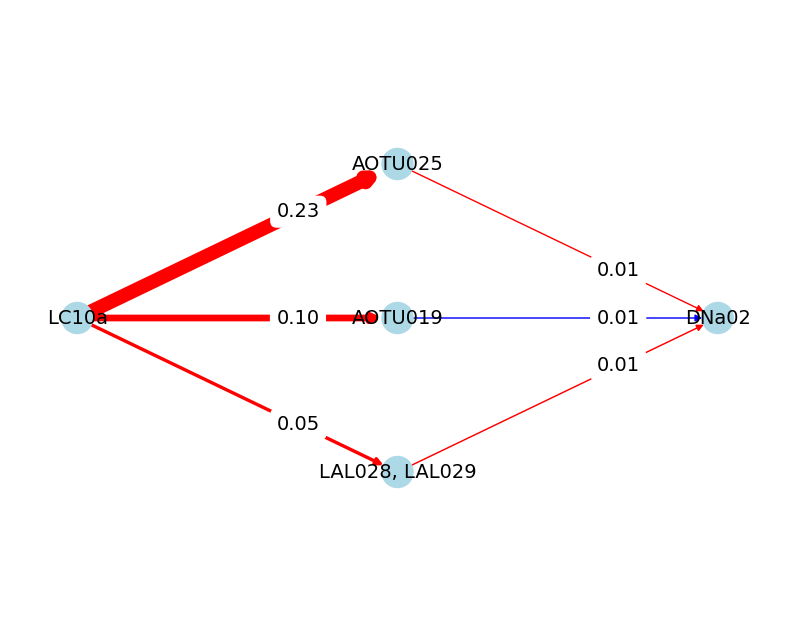

In [ ]:
# path finding
inidx = meta.idx[meta.cell_type == 'LC10a']
outidx = meta.idx[meta.cell_type == 'DNa02']
paths = find_paths_of_length(inprop, inidx, outidx, 2)
paths = group_paths(paths, idx_to_type, idx_to_type)
paths = filter_paths(paths, 0.01)
plot_layered_paths(paths, neuron_to_sign=type_to_sign)

In [ ]:
inidx = meta.idx[meta.coords.notna()] # get everything that's assigned a column
outidx = meta.idx[(meta.cell_type == 'LC10a') & (meta.side == 'right')]
df = result_summary(stepsn, inidx, outidx,
                    idx_to_coords, idx_to_root,
                    display_threshold=0, display_output=False)
hex_heatmap(df.iloc[:,:20])

In [ ]:
plot_mollweide_projection(df.iloc[:, :20])

# modelling

In [ ]:
sensory_indices = meta.idx[meta.cell_class == 'olfactory'].values
num_layers = 5

inprop_signed = add_sign(inprop, idx_to_sign)

model = MultilayeredNetwork(inprop_signed, sensory_indices, num_layers, threshold=0)

In [ ]:
# first load experimental data
door = load_dataset('DoOR_adult')

In [ ]:
# map from glomeruli to activation for one odour
glom2act1 = dict(door.loc[:, door.columns.str.contains(
    'vaccenyl acetate')].reset_index().values)
# turn this into a vector of ORN activations corresponding to the sensory_indices
v1 = np.array([glom2act1[idx_to_glomeruli[idx]] if idx_to_glomeruli[idx]
               in glom2act1 else 0 for idx in sensory_indices])
model_in = np.zeros((len(sensory_indices), num_layers)).astype(np.float32)
model_in[:, 0] = v1

In [ ]:
# run the model
activations = model(model_in)
activations.shape

torch.Size([138639, 5])

In [ ]:
neuron_activations = get_neuron_activation(activations, meta.idx[meta.cell_class == 'ALPN'], idx_to_group=idx_to_type)
neuron_activations

,group,time_0,time_1,time_2,time_3,time_4
0,"(M_adPNm4,M_adPNm5)a",0.246159,0.131755,0.000000,0.040793,0.025549
1,"(M_adPNm4,M_adPNm5)b",0.124100,0.081467,0.022181,0.043806,0.058694
2,"(M_adPNm4,M_adPNm5)c",0.179961,0.074817,0.047629,0.081764,0.007950
3,"(M_adPNm4,M_adPNm5)d",0.159937,0.122058,0.048067,0.058696,0.073777
4,"(M_lPNm12,M_lPNm13)a",0.012224,0.000000,0.000000,0.071670,0.217143
...,...,...,...,...,...,...
179,VP5+Z_adPN,0.000000,0.000000,0.000000,0.000000,0.043703
180,"VP5+_l2PN,VP5+VP2_l2PN",0.000915,0.000460,0.001698,0.028869,0.101688
181,V_ilPN,0.001284,0.004237,0.023449,0.329633,0.609852
182,V_l2PN,0.000000,0.000000,0.000000,0.000000,0.224055


In [ ]:
plot_timeseries(neuron_activations)